# Выявление закономерностей успешности видеоигр

Интернет-магазин, продающий по всему миру компьютерные игры поставил перед нами задачу - выяснить, от чего может зависеть успешность той или иной видеоигры. Это позволит заранее спланировать рекламные кампании для потенциально успешных продуктов.

Для ответа на поставленный вопрос будут использоваться данные из открытых источников о продажах видеоигр с оценками от пользователей и критиков, их жанрами и платформами выпуска.

Вся работа пройдёт в 6 этапов:
1. **[Загрузка и ознакомление с данными](#Загрузка-и-ознакомление-с-данными)**
2. **[Предобработка](#Предобработка-данных)**
3. **[Исследовательский анализ](#Исследовательский-анализ-данных)**
4. **[Составление портретов пользователей разных регионов](#Составление-портрета-пользователя-каждого-региона)**
5. **[Статистический анализ, или проверка гипотез](#Проверка-гипотез,-статистический-анализ)**
6. **[Общий вывод и рекомендации заказчику](#Общий-вывод)**

**Описание данных**

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
from IPython.display import display

## Загрузка и ознакомление с данными

Для начала ознакомимся с данными, проверим наличие дубликатов и количество ненулевых значений.

In [2]:
def data_present(ds):
    print('Количество дубликатов:', ds.duplicated().sum()) # Количество явных дубликатов
    display(ds.head())
    ds.info()
    display(ds.describe())

In [3]:
ds = pd.read_csv('datasets/games.csv') # Чтение датасета
data_present(ds)

Количество дубликатов: 0


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Дубликатов нет, но есть очень много пропусков в столбцах с рейтингом критиков, пользователей и ESRB. Рейтинг пользователей стал строкой. Также все названия столбцов начинаются с большой буквы. Разберёмся со всем на этапе предобработки.

## Предобработка данных

Начнём с названия столбцов. Приведём их к нижнему регистру.

In [4]:
ds.columns = ds.columns.str.lower() # Приведение наименований столбцов к нижнему регистру
ds.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Теперь проверим наличие менее явных дубликатов. Данные были получены из открытых источников, и не исключено, что информация о некоторых играх была взята с нескольких разных источников и сохранена множество раз в виде отдельных записей.

In [5]:
ds[ds[['name', 'platform', 'year_of_release']].duplicated()] # Вывод дубликатов по имени, платформе и году выпуска

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Всего 2 записи, в рамках нашего исследования ими можно пренебречь, поэтому перезапишем датасет без них.

In [6]:
ds = ds.drop_duplicates(subset=['name', 'platform', 'year_of_release']) # Сброс дубликатов
ds[ds[['name', 'platform', 'year_of_release']].duplicated()] 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Теперь типы данных. Учитывая что всё исследование основано на группировке игр по годам выпуска, записи без указания года не будут нам полезны. Удалим их, а столбец преобразуем в целочисленный тип

In [7]:
ds = ds[ds['year_of_release'].isna() == False] # Удаление записей с отсутствующим годом
ds['year_of_release'] = ds['year_of_release'].astype('int') # Преобразование года выпуска в целочисленный тип
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.4+ MB


Теперь посмотрим поближе на оценки от пользователей. Это дискретные числа, и их не так много, поэтому можем взглянуть на все уникальные значения.

In [8]:
print(ds['user_score'].unique()) # Уникальные значения
ds['user_score'].value_counts() # Частота встречаемости уникальных значений

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
0.3       2
0.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

tbd - to be determined = Подлежит уточнению, или будет определено. Рейтинга для этих игр нет, в рамках исследования можем со спокойной душой удалить значения. Пометка tbd, как и пропуски в данных о рейтинге, могли появиться, если подсчёт оценок изначально не проводился по требованию издателя, или оценок было слишком мало для формирования рейтинга.

In [9]:
ds.loc[ds['user_score'] == 'tbd', 'user_score'] = np.NaN # Замена всех tbd на NaN
ds['user_score'] = pd.to_numeric(ds['user_score'], errors='coerce') # Перевод типа значенений столбца в дробный
ds.info()
ds['user_score'].value_counts() # Проверяем что замена прошла успешно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


7.8    322
8.0    285
8.2    276
8.3    252
7.5    249
      ... 
2.3      2
0.7      2
1.1      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64

In [10]:
ds['rating'] = ds['rating'].fillna('N/A')
ds['rating'].value_counts()

N/A     6677
E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Пропусков в столбцах с рейтингами критиков и пользователей слишком много для заполнения их чем-либо. Их удаление также может повлиять на результаты исследования, поэтому пропуски оставим нетронутыми. Они могли появиться как из-за технической ошибки при формировании датасета, так и из-за того, что информации о разных рейтингах некоторых игр просто нет. Например, у малоизвестных инди-игр. Пропуски рейтинга ESRB мы заполнили индикаторным значением, и при исследовательском анализе проверим наличие закономерностей отсутствия данных.

Теперь подготовим данные о продажах к анализу - подсчитаем суммарные продажи во всех регионах и запишем в отдельный столбец

In [11]:
ds['total_sales'] = ds[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1) # Общее число продаж во всех регионах
ds.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,N/A,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,N/A,31.38


На этом предобработку можно заканчивать. Мы привели названия столбцов к нижнему регистру, удалили записи с отсутствующими значениями годов и перевели их в целочисленный тип, удалили значения tbd в пользовательском рейтинге и привели столбец к дробному типу данных.

## Исследовательский анализ данных

### Количество выпущенных игр в разные годы

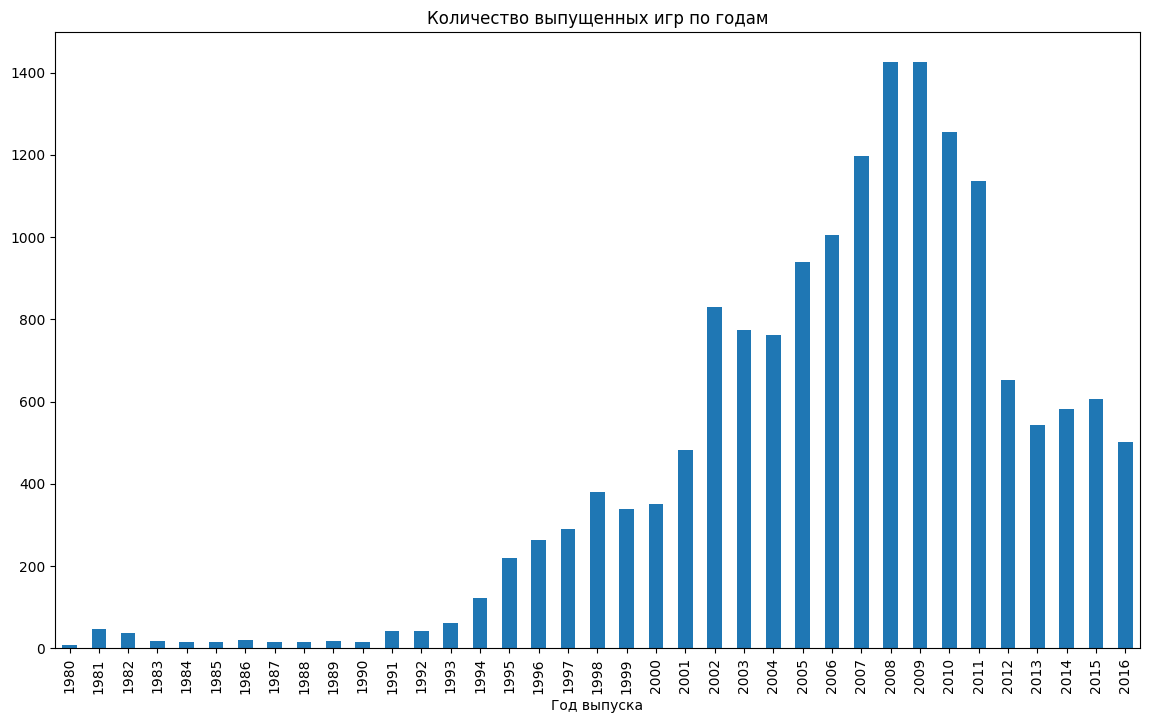

In [12]:
ds['year_of_release'].value_counts().sort_index().plot(kind='bar', figsize=(14,8));
plt.title('Количество выпущенных игр по годам');
plt.xlabel('Год выпуска');

С 1980 по 1990 годы игры выпускались в крайне малых количествах, и неохотно, а с 1991 года игровая индустрия начала рост, пока не достигла своего пика в 2008-2009 году, после количество игр пошло на спад.

### Продажи игр на разных платформах

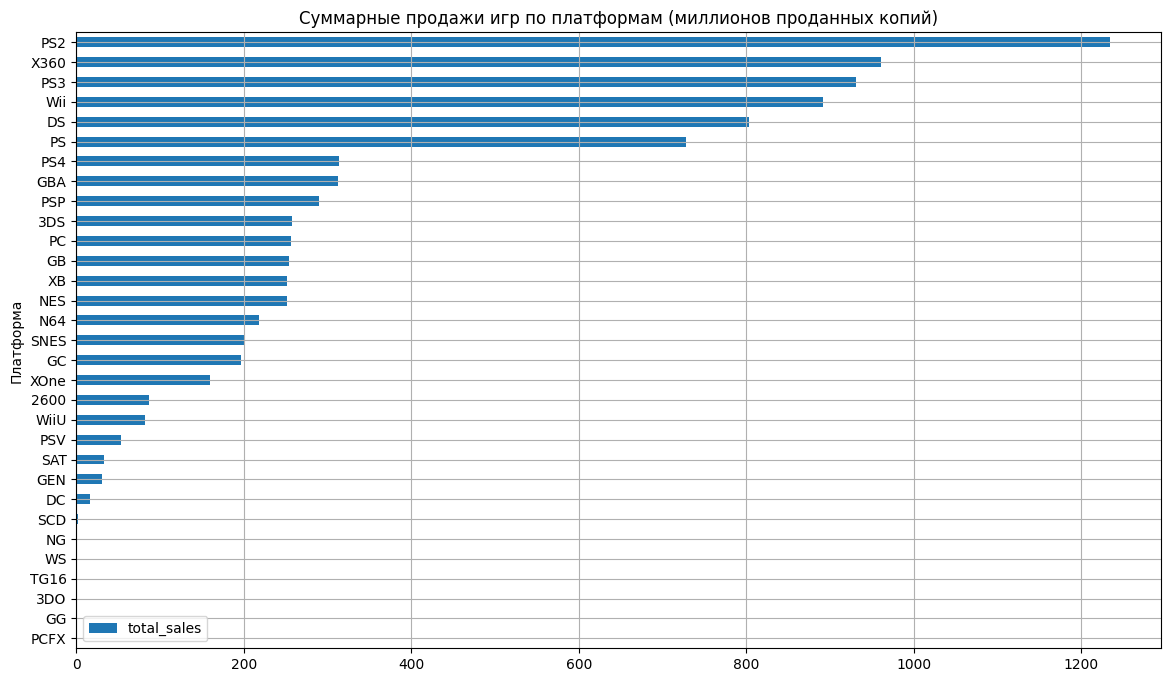

In [13]:
ds.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales').plot(kind='barh', figsize=(14, 8), grid=True);
plt.title('Суммарные продажи игр по платформам (миллионов проданных копий)');
plt.ylabel('Платформа');

Построим отдельные графики для самых популярных платформ, чтобы проследить, как менялись их продажи от года к году. 

In [14]:
def platform_sales_present(ds, platform, size=(6, 2), kind='bar', title='Количество продаж по годам на платформе', label='Год выпуска'): # Функция для быстрой визуализации количества продаж по годам
    ds[ds['platform'] == platform]\
    .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .sort_index()\
    .plot(kind=kind, grid=True, figsize=size)
    plt.title(f'{title} {platform}')
    plt.ylabel('Миллионов проданных копий')
    plt.xlabel(label)

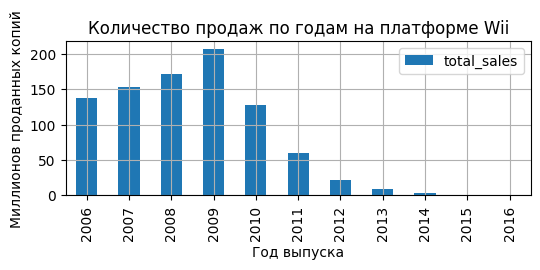

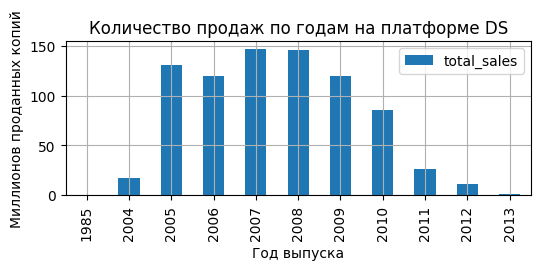

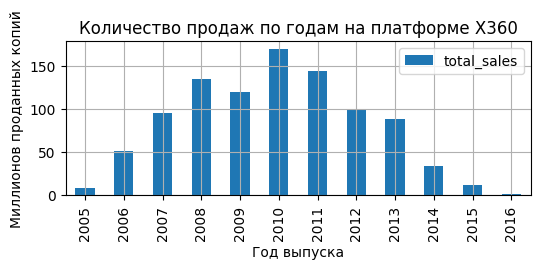

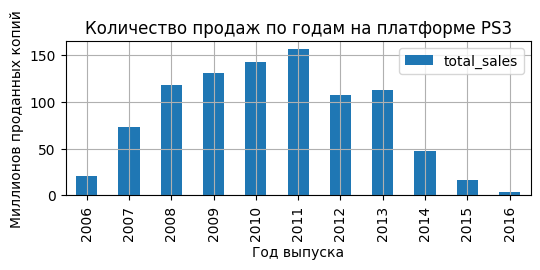

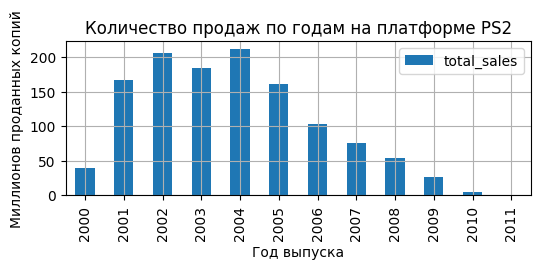

In [15]:
for i in ds['platform'].unique():
    if ds.loc[ds['platform'] == i, 'total_sales'].sum()>800:
        platform_sales_present(ds, i)

В среднем, популярные платформы остаются актуальными ~8-10 лет. Практически у каждой популярной платформы примерно схожее распределение - резкий взлёт популярности на старте продаж, несколько лет сравнительной стабильности, и плавный спад продолжающийся около 3-4 лет

Также, в записях о платформе DS видна аномалия, продажи в 1985 году, хотя сама платформа вышла значительно позже.

In [16]:
ds.query('platform == "DS" and year_of_release == 1985') # Срез аномальных значений

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,N/A,0.02


Всего одна запись. Перезапишем датасет без неё.

In [17]:
ds = ds[ds.index != 15957]
ds.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


### Выбор актуального периода

За актуальный период мы возьмём средний период стабильно высокого количества продаж на популярных платформах(Исключая период медленного спада популярности) - ~5 лет, то есть в дальнейшем исследовании мы будем использовать данные с 2012 по 2016 год включительно. Это позволит затронуть в ходе анализа платформы на пике популярности.

In [18]:
ds_current = ds[ds['year_of_release'] >= 2012]
ds_current = ds_current.reset_index(drop=True)
ds_current.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,N/A,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,N/A,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


### Анализ популярности платформ

Теперь рассмотрим самые популярные платформы за актуальный период.

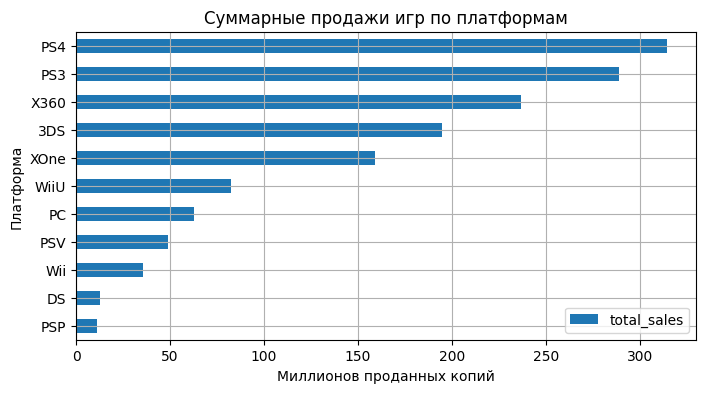

In [19]:
ds_current.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales').plot(kind='barh', figsize=(8, 4), grid=True);
plt.title('Суммарные продажи игр по платформам');
plt.ylabel('Платформа');
plt.xlabel('Миллионов проданных копий');

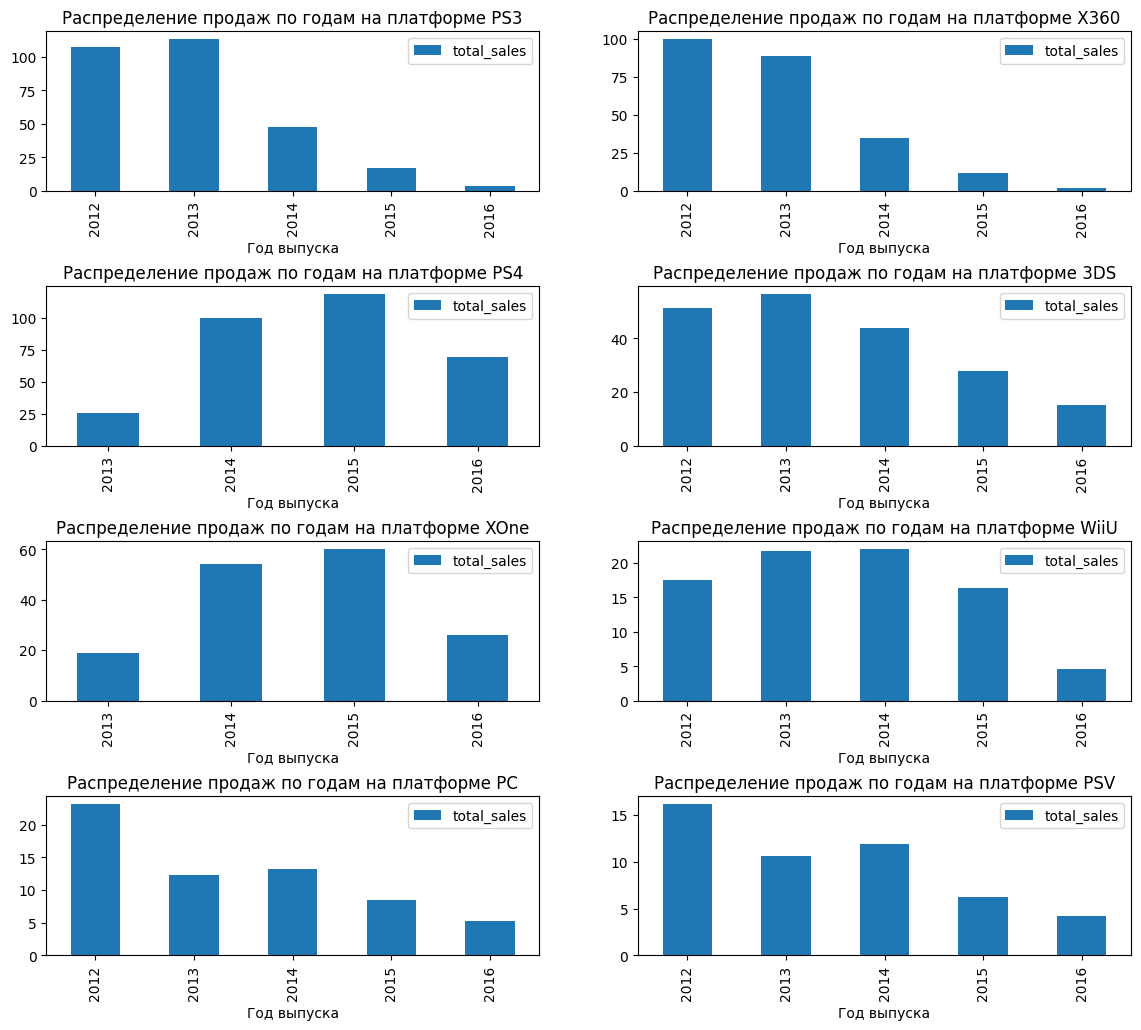

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(14, 12)) # Расположение сабплотов
plt.subplots_adjust(hspace=0.6) # Вертикальный отступ

for i, j in enumerate([platform for platform in ds_current['platform'].unique() if ds_current.loc[ds_current['platform'] == platform, 'total_sales'].sum() > 45]):
    ds_current[ds_current['platform'] == j].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', ax=axs[i//2, i%2], title=f'Распределение продаж по годам на платформе {j}', xlabel='Год выпуска')

PS3 и X360 имеют практически идентичное распределение, при этом к 2016 году продажи на них упали почти до нуля. 
PS4 и XOne с точно так-же схожим распределением в 2015 году находились на своём пике, а в 2016 виднеется небольшой спад продаж.
Продажи на 3DS, WiiU и PSV, хоть и с некоторыми различиями, но движутся вниз. А продажи на персональных компьютерах колеблются, что может быть связано с развитым пиратством на этой платформе.

В целом - самыми перспективными на ближайшие несколько лет представляются платформы PS4 и XOne. Также едва-ли потеряют свою актуальность персональные компьютеры.

### Глобальные продажи по платформам

Теперь построим 'Ящик с усами' глобальных продаж в разбивке по платформам и проследим за результатом.

In [21]:
def so_many_boxplots(value, x, y): # Функция для быстрого отображения боксплотов
    pop_platforms = pd.DataFrame()
    for i in [j for j in ds_current[value].unique() if ds_current.loc[ds_current[value] == j, 'total_sales'].sum() > 45]:
        pop_platforms[i] = ds_current.loc[ds_current[value] == i, 'total_sales'].reset_index(drop=True)
    # Цикл перебирает все уникальные названия значений, общая сумма продаж на которых более 45, и записывает в пустой датафрейм со сбросом индекса
    pop_platforms.boxplot(column=[platform for platform in ds_current[value].unique() if ds_current.loc[ds_current[value] == platform, 'total_sales'].sum() > 45], figsize=(8, 4));
    plt.ylim(x, y);

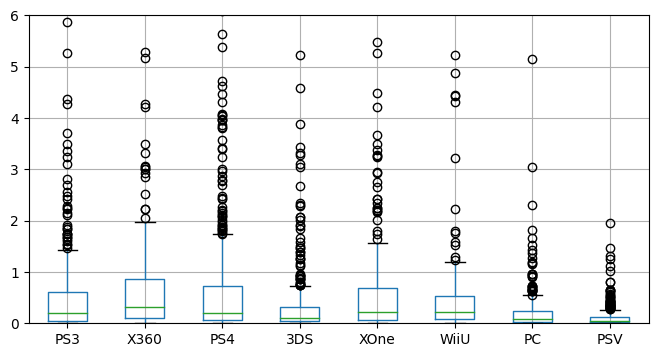

In [22]:
so_many_boxplots('platform', 0, 6)

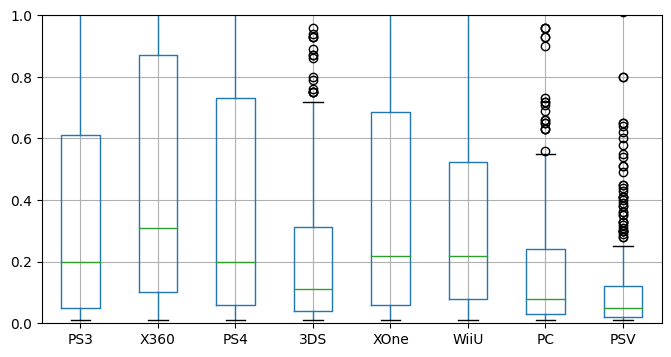

In [23]:
so_many_boxplots('platform', 0, 1)

Напоминаю, каждая точка на графике - это одна игра, вышедшая на соответствующей платформе. Расположение точки на графике отражает, сколько миллионов копий игры было продано на этой платформе. Зелёная линия отражает медианное значение продаж, а границы "ящика" - первый и третий квартили. Значений внутри ящика и его "усов" слишком много для визуализации, поэтому мы можем просто представить сплошную линию. Пройдёмся по всем графикам по порядку.
1. PS3 - Медиана на 0.2, нижний ус упирается в ноль. Очень много игр с малыми продажами, но достаточно много и лидеров рынка, превышающих 1.5 миллиона проданных копий.
2. X360 - Медианное значение около 0.3, точно так-же много игр с малыми продажами, но при этом разброс внутри квартилей гораздо сильнее. На этой платформе меньше аномально популярных игр, но гораздо больше высоких значений, остающихся внутри "усов"
3. PS4 - Значения платформы очень схожи с её младшим братом PS3, однако третий квартиль приподнялся, что говорит о увеличении числа хорошо продаваемых игр. Количество аномально высоких значений продаж так-же увеличилось.
4. 3DS - Крайне много около-нулевых значений, на эту платформу выпускают огромное количество малопродаваемых игр.
5. XOne - Медиана снизилась по сравнению с X360. На новую версию платформы стало выходить больше игр, в основном малопродаваемых, но также и крайне высоко продаваемых.
6. WiiU - Аномально высоких значений крайне мало.
7. PC - Первый квартиль крайне близко к нулю. На эту платформу очень много игр, которые почти не продаются.
8. PSV - Первый квартиль упирается в ноль, третий не превышает одной десятой. Большую часть игр на платформе купили менее 100 000 раз

### Определение зависимости продаж от отзывов критиков и пользователей

Для определения зависимости мы возьмём одну самую популярную платформу за актуальный период - PS4. Для начала построим диаграмму рассеяния для обоих типов отзывов.

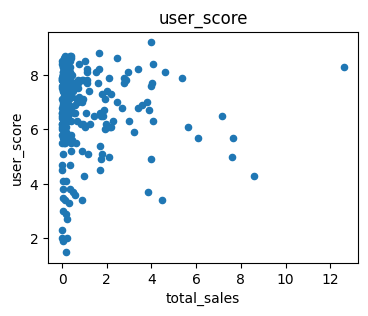

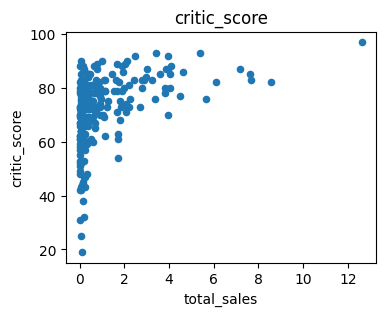

In [24]:
for i in ['user_score', 'critic_score']:
    ds_current[ds_current['platform'] == 'PS4'].plot.scatter(x='total_sales', y=i, title=i, figsize=(4,3));

Пользователи чаще ставят высокие оценки малопродаваемым играм, чем критики. Также гораздо чаще возникают ситуации, когда пользователи ставят низкие оценки играм, проданным более 4 миллионов раз. Критики-же почти никогда не ставят низкие оценки, если игру купили более 2 миллионов раз.

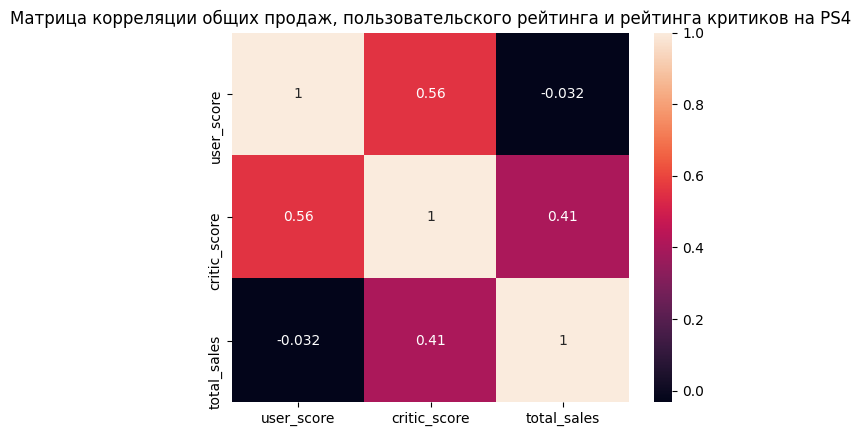

In [25]:
sns.heatmap(ds_current.loc[ds_current['platform'] == 'PS4', ['user_score', 'critic_score', 'total_sales']].corr(), annot=True);
plt.title('Матрица корреляции общих продаж, пользовательского рейтинга и рейтинга критиков на PS4');

Корреляция между продажами и отзывами пользователей почти нулевая, зависимости между этими величинами нет.
А между продажами и отзывами критиков прослеживается определённая зависимость. Можно утверждать, что отзывы критиков могут влиять на число продаж, но определённо существуют и другие факторы.

Теперь посмотрим возникнет-ли подобная картина на других платформах.

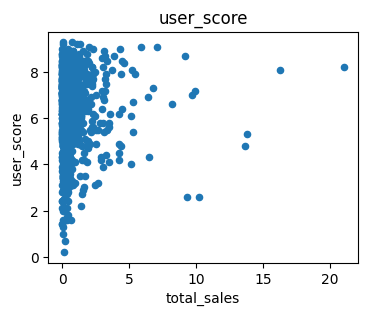

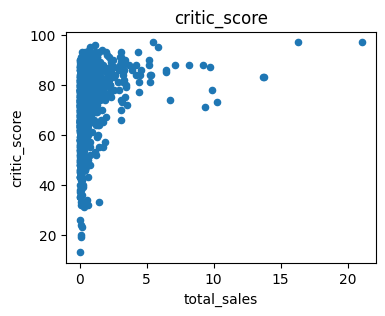

In [26]:
for i in ['user_score', 'critic_score']:
    ds_current[ds_current['platform'] != 'PS4'].plot.scatter(x='total_sales', y=i, title=i, figsize=(4,3));

Определенно видна схожесть с картиной, что мы видели при рассмотрении показателей PS4. Пользователи чаще критиков ставят низкие оценки хорошо продаваемым играм. 

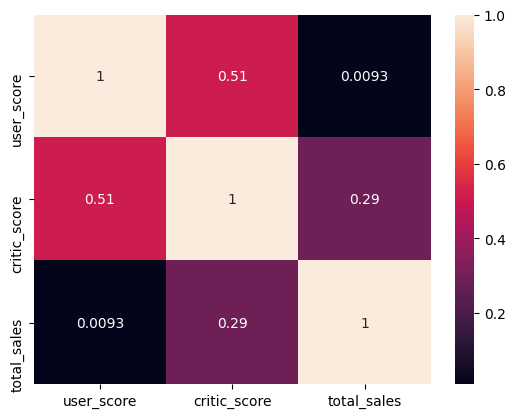

In [27]:
sns.heatmap(ds_current.loc[ds_current['platform'] != 'PS4', ['user_score', 'critic_score', 'total_sales']].corr(), annot=True);

На других платформах ситуация схожая, однако зависимость продаж от оценок критиков снизилось чуть-ли не вдвое, что уже можно назвать едва заметной зависимостью. От пользовательского рейтинга продажи всё так-же не зависят абсолютно никак.

### Распределение игр по жанрам

Взглянем поближе на количество продаж у каждого жанра

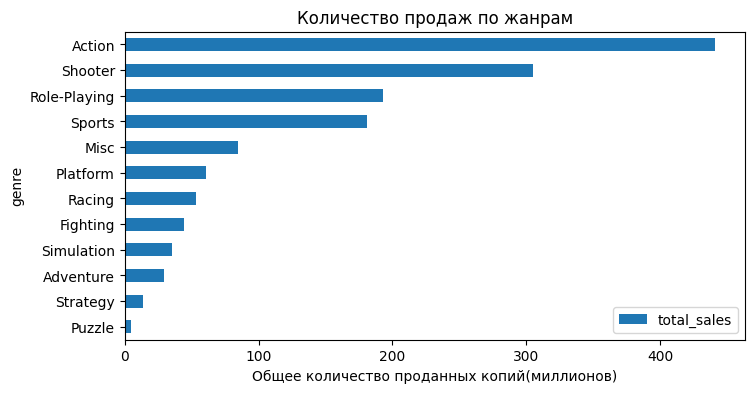

In [28]:
ds_current.pivot_table(index='genre', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales')\
.plot(kind='barh', figsize=(8,4), title='Количество продаж по жанрам');
plt.xlabel('Общее количество проданных копий(миллионов)');

Общее число продаж у экшенов больше всего. Также посмотрим на распределение значений у жанров с б**о**льшим числом продаж.

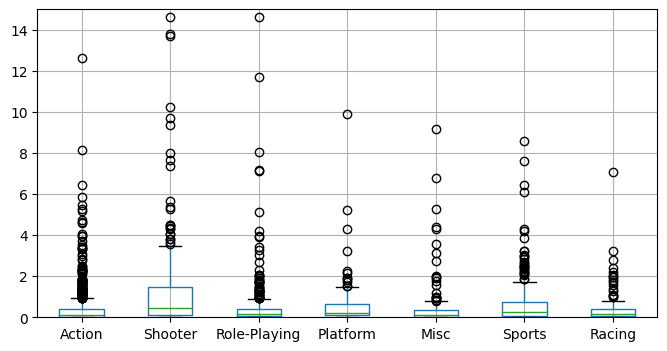

In [29]:
so_many_boxplots('genre', 0, 15)

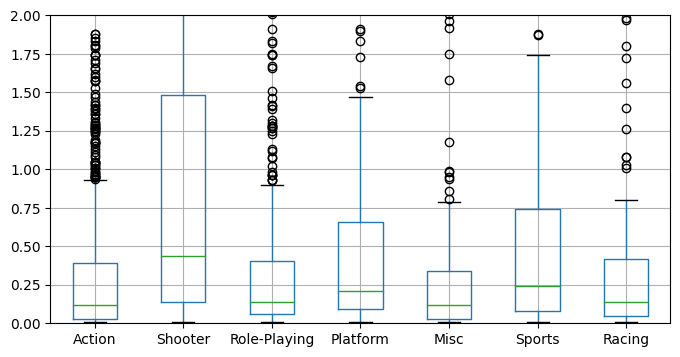

In [30]:
so_many_boxplots('genre', 0, 2)

Теперь всё не так однозначно. Экшенов очень много, но абсолютное большинство едва-едва продаётся. Аномально высокие значения в огромных количествах вытягивают жанр на первое место по общему числу продаж. А шутеры тем временем показывают гораздо более стабильный результат. В целом выходит, что у игры жанра шутер гораздо больше шансов на высокое число продаж.

## Составление портрета пользователя каждого региона

В рамках исследования мы определим для пользователей каждого региона(NA, EU, JAP)
1. 5 самых популярных платформ
2. 5 самых популярных жанров
3. Зависимость продаж игр от рейтинга ESRB

In [31]:
def na_eu_jp(data, index): # Функция для быстрой презентации 5 самых популярных позиций в разных регионах для переданного индекса
    for j in ['na_sales', 'eu_sales', 'jp_sales']:
        ds_current.pivot_table(index=index, values=j, aggfunc='sum')\
        .sort_values(by = j)\
        .tail()\
        .plot(kind='barh', grid=True, title=f'Продажи по {index} в регионе {j}', figsize=(3, 2));
        plt.xlabel('Миллионов проданных копий игр')

### Популярные платформы

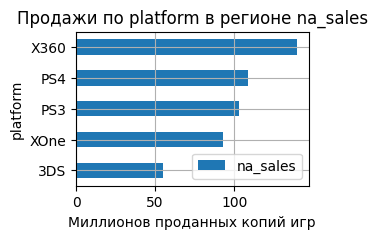

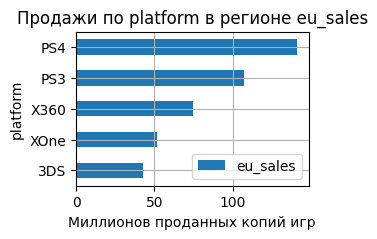

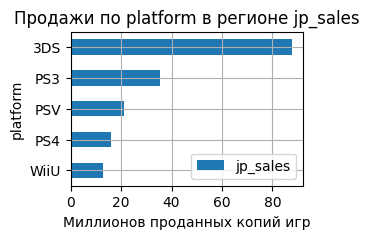

In [32]:
na_eu_jp(ds_current, 'platform')

У каждого региона свой фаворит среди платформ. У Северной Америки это X360, у Европы PS4, а у Японии портативная приставка 3DS

### Популярные жанры

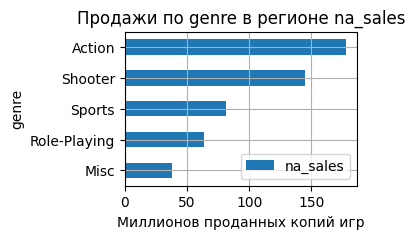

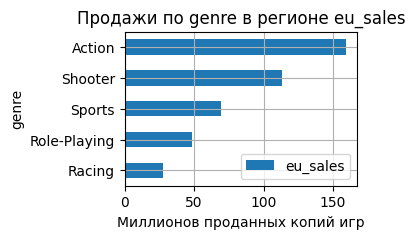

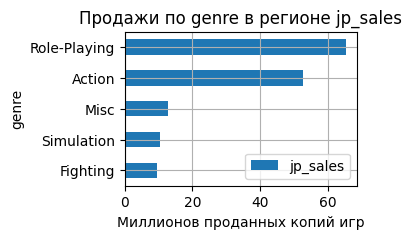

In [33]:
na_eu_jp(ds_current, 'genre')

Самыми популярными жанрами в Северной Америке и Европе являются экшены и шутеры, а в Японии ролевые игры и экшены.

### Зависимость продаж от рейтинга ESRB

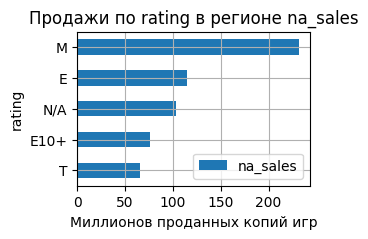

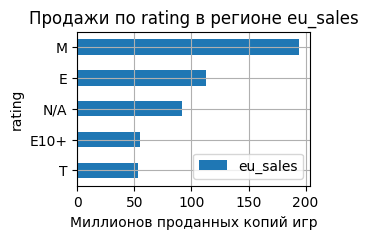

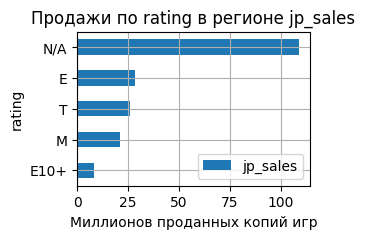

In [34]:
na_eu_jp(ds_current, 'rating')

В Северной Америке и Европе преобладают игры с рейтингом M(17+). В Японии чрезвычайно много игр без установленного рейтинга (N/A). Возможно он не пользуется популярностью у Японского гейм-дева. Самые популярные рейтинги среди установленных - E(для всех возрастов) и T(для подростков), но учитывая количество игр без рейтинга, реальная картина скорее всего будет отличаться.

## Проверка гипотез, статистический анализ

В рамках статистического анализа мы рассмотрим 2 пары гипотез, и на основании полученных в результате тестов p-значений, отвергнем или не отвергнем нулевые гипотезы в пользу альтернативных.

Нулевые гипотезы будут формироваться как "Среднее значение `a` равно среднему значению `b`", где a и b - выборки записей, соответствующие определенным условиям.

Альтернативные гипотезы будут формироваться как "Среднее значение `a` не равно среднему значению `b`", соответственно. В обоих тестах нас не интересует какое из значений больше или меньше, поэтому использоваться будут двухсторонние т-тесты

Полученное в результатах тестов `p-value`, обозначающее вероятность получить наблюдаемые результаты при условии, что нулевая гипотеза верна, будет сравниваться с уровнем статистической значимости `alpha`, задаваемое до теста. 

Если `p-value` будет больше `alpha` - нулевая гипотеза остаётся в силе. 

Если `p-value` будет меньше `alpha` - нулевая гипотеза отвергается в пользу альтернативной.

In [35]:
alpha = 0.02 # Уровень стат. значимости 2%

In [36]:
def pvalue_check(arr1, arr2): # Функция для презентации результатов t-тестов
    ttest = st.ttest_ind(arr1, arr2, equal_var=False)
    print(f'pvalue:{ttest.pvalue}\nСреднее первой выборки: {arr1.mean().round(1)}')
    if type(arr2) == type(arr1): 
        print(f'Среднее второй выборки: {arr2.mean().round(1)}')
    else:
        print(f'Предполагаемое среднее: {arr2}')
    if ttest.pvalue<alpha:
        print('Нулевая гипотеза отвергается')
    else:
        print('Нулевая гипотеза не может быть опровергнута')

### Пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - Среднее значение пользовательского рейтинга XOne равно среднему значению пользовательского рейтинга PC

Альтернативная гипотеза - Среднее значение пользовательского рейтинга XOne не равно среднему значению пользовательского рейтинга PC

In [37]:
pvalue_check(ds_current.query('platform == "XOne" and user_score.isna() == False')['user_score'],\
             ds_current.query('platform == "PC" and user_score.isna() == False')['user_score']) # Двухсторонний ttest для независимых выборок двух платформ

pvalue:0.5489537965134912
Среднее первой выборки: 6.5
Среднее второй выборки: 6.4
Нулевая гипотеза не может быть опровергнута


У нас есть основания полагать, что среднее значение оценок пользователей у платформ Xbox One и PC равны

### Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза - Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

Альтернативная гипотеза - Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

In [38]:
pvalue_check(ds_current.query('genre == "Action" and user_score.isna() == False')['user_score'],\
             ds_current.query('genre == "Sports" and user_score.isna() == False')['user_score']) # Двухсторонний ttest для независимых выборок двух жанров

pvalue:5.98945806646755e-20
Среднее первой выборки: 6.8
Среднее второй выборки: 5.5
Нулевая гипотеза отвергается


P-значение значительно ниже уровня статистической значимости, нулевая гипотеза может быть отвергнута в пользу альтернативной. Соответственно, мы можем утверждать, что средние пользовательские рейтинги жанра Action и Sports действительно не равны друг другу.

## Общий вывод

**Предобработка**

В рамках предобработки:
- Названия столбцов были приведены к нижнему регистру.
- Записи без указания года были удалены, а столбец приведён к целочисленному типу.
- Были удалены значения tbd в пользовательском рейтинге, столбец приведён к дробному типу.
- Создан новый столбец с суммой продаж во всех регионах.

**Исследовательский анализ**

В рамках исследовательского анализа была визуализирована информация о:
- Количестве выпущенных игр в разные годы
- Продажах игр на разных платформах
- Продажах игр на разных платформах за актуальный период(2012-2016 включительно)
- Распределении продаж игр по годам на самых популярных платформах.
- Распределении количества продаж каждой игры при помощи "Ящиков с усами" для самых популярных платформ.
- Распределении числа продаж относительно пользовательского рейтинга и рейтинга критиков.
- Корреляции числа продаж, пользовательского рейтинга и рейтинга критиков.
- Распределении числа продаж по разным жанрам.

Также были составлены портреты пользователей трёх основных регионов - Северная Америка, Европа и Япония.
1. Северная Америка
 - Платформа - X360
 - Жанр игры - Action
 - Рейтинг ESRB - M
2. Европа
 - Платформа - PS4
 - Жанр игры - Action
 - Рейтинг ESRB - M
3. Япония
 - Платформа - 3DS
 - Жанр игры - Role-Playing
 - Рейтинг ESRB - N/A(Пользователи из Японии чаще всего покупают игры без установленного рейтинга ESRB, в этом он нам не поможет)

**Статистический анализ**

Были проверены 2 гипотезы и получены следующие результаты:
1. Среднее значение пользовательского рейтинга XOne равно среднему значению пользовательского рейтинга PC
2. Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

**Рекомендации заказчику**

- Использовать рекламное продвижение продуктов в разных регионах в соответствии с полученными портретами пользователей.
- Тратить больше усилий на рекламу высоко оценённых критиками продуктов.